# PL612-Baldy analysis of initial land survey

The first order of business is to read the CSV file containing the ETRS89 measurements of the surface of the Baldy station.

In [96]:
%pylab inline
import csv
with open('BALDY xyz-ETRF2000.txt', 'r') as csv_file:
    csv_rows = [(row[0], array([float(num) for num in row[1:4]])) 
                for row in csv.reader(csv_file, delimiter=',')
                if 'ETRS' not in row[1]]
    
with open('XYZ_GRS-ETRF2000.txt', 'r') as csv_file:
    csv_rows_ref = [(row[0], array([float(num) for num in row[1:4]])) 
                    for row in csv.reader(csv_file, delimiter=',')
                    if len(row) > 3 and 'ETRS' not in row[1]]
print(len(csv_rows))
csv_rows[0:3]
print(len(csv_rows))
csv_rows[0:3]
print(csv_rows_ref)

Populating the interactive namespace from numpy and matplotlib
190
190
[('             910', array([ 3551451.9736,  1334171.7701,  5110186.3775])), ('             920', array([ 3551452.6561,  1334177.4701,  5110184.4139])), ('             930', array([ 3551450.7434,  1334178.1796,  5110185.7784])), ('             940', array([ 3551449.9671,  1334172.4074,  5110187.5766])), ('             010', array([ 3551440.8562,  1334097.6167,  5110212.8361])), ('             011', array([ 3551507.2361,  1334076.3187,  5110173.5885])), ('             012', array([ 3551525.4118,  1334231.3447,  5110120.0893])), ('             013', array([ 3551459.5304,  1334252.8397,  5110160.0289]))]


It seems like we succeeded in reading the file. The variable *position_dict* can be used to look up positions based on the name of the point. *all_positions* is an array of all 3D ETRS coordinates, and *all_names* holds the corresponding names.

In [97]:
position_dict = dict(csv_rows)
all_positions = array([row[1] for row in csv_rows])
all_names = [row[0] for row in csv_rows]
container_pos_etrs = array([row[1] for row in csv_rows_ref[:4]])
container_names    = [row[0] for row in csv_rows_ref[:4]]
border_pos_etrs = array([row[1] for row in csv_rows_ref[4:]])
border_names    = [row[0] for row in csv_rows_ref[4:]]

mean_position = all_positions.mean(axis=0)
print('Mean position (ETRS89): ', mean_position)

Mean position (ETRS89):  [ 3551510.08303279  1334141.24830537  5110155.56365142]


And in geographic coordinates in radians and meters:

In [98]:
from lofargeo import *
geo_mean = geographic_from_xyz(mean_position)
print('''lat_rad : %(lat_rad).10f rad
lon_rad : %(lon_rad).10f rad
height_m: %(height_m).3f m''' % geo_mean)

lat_rad : 0.9353819916 rad
lon_rad : 0.3593444793 rad
height_m: 172.726 m


The normal vector to the WGS84 ellipsoid is then

In [99]:
ellipsoid_normal = normal_vector_ellipsoid(geo_mean['lon_rad'], geo_mean['lat_rad'])
repr(ellipsoid_normal)

'array([ 0.55560203,  0.20871448,  0.80482585])'

## Slope of the field and selection of subset of points

The first inspection of the data is done with respect to the plane parallel to the tangent plane of the WGS84 ellipsoid at the mean position of all measured points, that goes right through the mean coordinate of all measured points. We determine a transformation_matrix that ensures that transformed "x" will be pointing east, "y" towards geographic north, and "z" up and perpendicular to the tangent plane of the ellipsoid at the longitude and latitude of the mean position.

In [100]:
local_north_projection = projection_matrix(mean_position, ellipsoid_normal)
local_north_xyz = transform(all_positions, mean_position, local_north_projection.T)

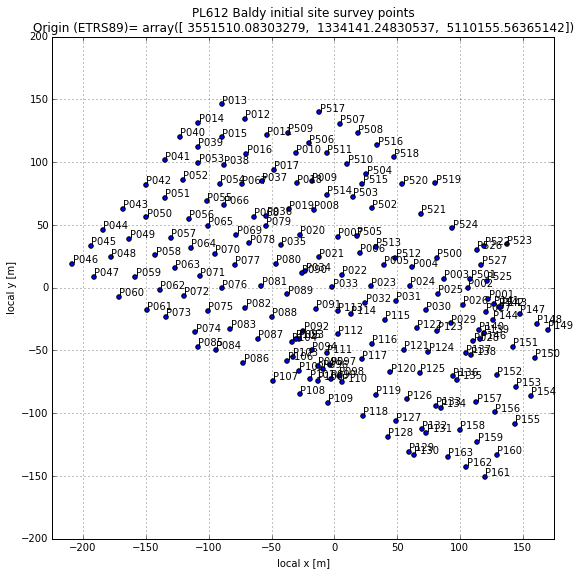

In [101]:
figure(figsize=(9,9))
scatter(local_north_xyz[:,0], local_north_xyz[:,1])
for name, offset in zip(all_names, local_north_xyz):
    text(offset[0]+1, offset[1]+1
         , name)
axis('equal')
grid()


title('PL612 Baldy initial site survey points\nOrigin (ETRS89)= %r' %
      mean_position)
xlabel('local x [m]')
ylabel('local y [m]')

The following function interpolates between unstructured points in 3D space.

In [102]:
xyz_interpol_fn = interpolation_function(local_north_xyz)
x_m, y_m = meshgrid(arange(-220, 180), arange(-160, 160))
z_m = xyz_interpol_fn(x_m, y_m)

Now let's plot a map of elevation of the selection relative to the mean position of all points.

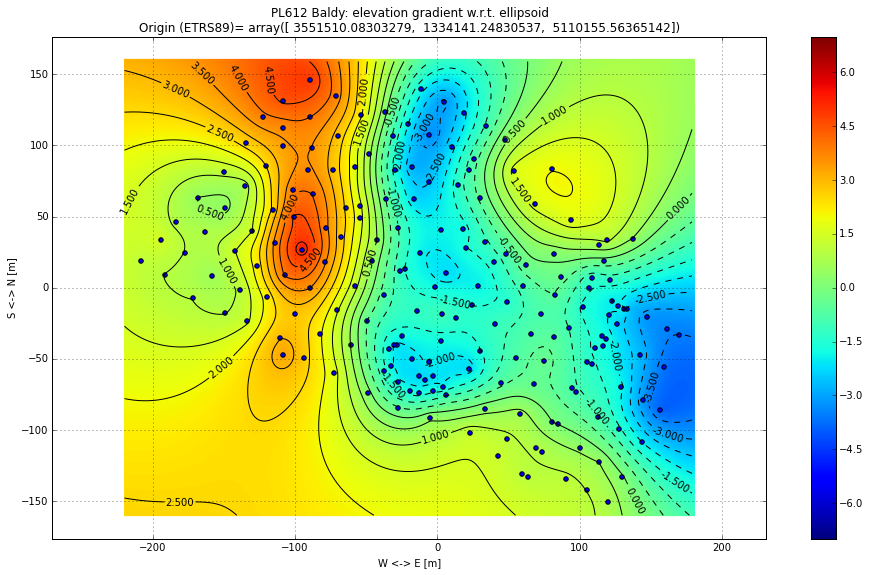

In [103]:
figure(figsize=(16,9))
imshow(z_m, origin='lower', vmin=-7, vmax=7.0, extent=(-220.5, 180.5, -160.5, 160.5))
colorbar()
cnt = contour(x_m, y_m, z_m, levels=arange(-10.0, +10.0, 0.50), colors='black')
cnt.clabel(inline=True)
xlabel('W <-> E [m]')
ylabel('S <-> N [m]')
axis('equal')
grid()
title('PL612 Baldy: elevation gradient w.r.t. ellipsoid\nOrigin (ETRS89)= %r' %
      mean_position)
scatter(local_north_xyz[:,0], local_north_xyz[:,1])


## Best fit plane and deviations from that plane

Because I do not yet have a map of the Baldy station, I have used all points that might hold the LBA and HBA stations to fit a plane through. As soon as I have a drawing of the area, and ETRS89 coordinates of at least 4 points that are marked clearly on that drawing, I can make a better fit.

The red points below (the ones in the *selection_xyz* and *selection_etrs* variables) are used to fit the best fit plane to the station.  They are selected, because it looks like an LBA station would best fit somewhere near the origin in the above map, and an HBA field somewhat to the east of the LBA field, near (80, 0) or thereabouts. Assuming that that is the case, I can make a smaller selection of points, and fit a plane to that area.

In [104]:
min_x, max_x = -50, 150
min_y, max_y = -50, 50
selection_xyz = array([xyz for xyz in local_north_xyz
                      if xyz[0] > min_x and xyz[0] < max_x 
                      and xyz[1]> min_y and xyz[1] < max_y])
selection_etrs = array([etrs for etrs, xyz in zip(all_positions, local_north_xyz)
                      if xyz[0] > min_x and xyz[0] < max_x
                      and xyz[1]> min_y and xyz[1] < max_y])
print ('The selection contains %d points.' % len(selection_etrs))

The selection contains 60 points.


In [105]:
solution = fit_plane(selection_etrs)
rotation_matrix = projection_matrix(LOFAR_XYZ0_m, solution['normal'])
print('Normal vector: ', repr(solution['normal']))
print('Mean position: ', repr(solution['mean']))
print('Rotation matrix:\n', repr(rotation_matrix))

Normal vector:  array([ 0.56839874,  0.21324349,  0.79463834])
Mean position:  array([ 3551494.3549715 ,  1334192.9752425 ,  5110151.53434267])
Rotation matrix:
 array([[-0.20342238, -0.79720901,  0.56839874],
       [ 0.97226605, -0.09605178,  0.21324349],
       [-0.11540393,  0.59601329,  0.79463834]])


In [106]:
CHBA_ETRS = array([3551484.940, 1334203.068, 5110155.560]) #array([3551486.858, 1334197.554, 5110155.668])
CLBA_ETRS = array([3551479.568, 1334128.297, 5110179.468])#array([3551479.039, 1334123.598, 5110181.107])

In [107]:
station_pqr = transform(all_positions, CLBA_ETRS, rotation_matrix.T)
selection_pqr = transform(selection_etrs, CLBA_ETRS, rotation_matrix.T)
station_height_deviation_fn = interpolation_function(station_pqr)
print('p range: ', station_pqr[:,0].min(),'--', station_pqr[:,0].max())
print('q range: ', station_pqr[:,1].min(),'--', station_pqr[:,1].max())

p range:  -199.207163008 -- 182.603988405
q range:  -164.709983941 -- 94.8874045823


In [108]:
p_m, q_m = meshgrid(arange(-60, 140), arange(-90, 60))
r_m = station_height_deviation_fn(p_m, q_m)

In [109]:
def square_corners(width, angle_rad=0.0):
    rot_mat = array([[cos(angle_rad), -sin(angle_rad)],
                     [sin(angle_rad), cos(angle_rad)]])
    corners = array([[-1, 1.0],[1.0, 1.0],[1.0, -1.0],[-1.0, -1.0],[-1.0, 1.0]])*width/2.0
    return array([dot(rot_mat, point) for point in corners])
HBA_CIRCLE_DIAMETER = 62.0
LBA_CIRCLE_DIAMETER = 75.0

def circle_points(diameter_m, num_points=100):
    phases = arange(0.0, 2*pi+2*pi/(2*num_points), 2*pi/(num_points-1))
    x = cos(phases)*diameter_m/2.0
    y = sin(phases)*diameter_m/2.0
    return concatenate([x.reshape((num_points, 1)), y.reshape((num_points, 1))], axis=1)

[[ -2.58053773e+01   5.36961244e+01  -2.03054117e+00]
 [ -5.54865297e+01  -2.05689108e+01  -2.95972972e-02]
 [  9.77166603e+01  -8.18354997e+01   8.47218308e-01]
 [  1.27408084e+02  -7.57435426e+00  -2.78480099e-01]
 [ -2.58053773e+01   5.36961244e+01  -2.03054117e+00]]
-21.7966741991
[ 0.  0.  0.]
[  7.43635967e+01  -2.57139800e+01  -3.46013546e-04]
[  7.43635967e+01  -2.57139800e+01  -3.46013546e-04]


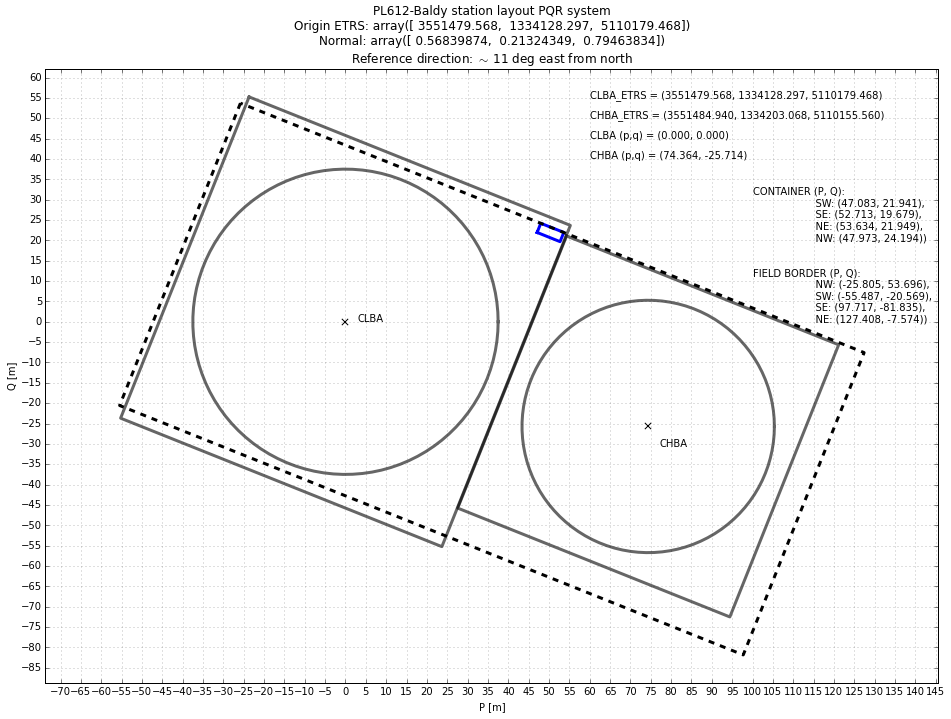

In [110]:
figure(figsize=(16, 11))
#imshow(r_m, origin='lower', extent=(-150.5, 100.5, -55.5, 100.5), vmin=-4, vmax=+4, alpha=0.3)
grid(alpha=0.5)
#cb = colorbar()
#cb.set_label('Height deviation [m]')
#cnt = contour(p_m, q_m, r_m, levels=arange(-10.0, +10.0, 0.5), colors='black', alpha=0.3)
#cnt.clabel(inline=True)
axis('equal')
title('''Deviations from best-fit plane
Origin ETRS: %r\nNormal: %r''' %
      (solution['mean'], solution['normal']))
xlabel('P [m]')
ylabel('Q [m]')
xticks(arange(-200, 200, 5))
yticks(arange(-200, 200, 5))

#scatter(station_pqr[:,0], station_pqr[:,1], alpha=0.5)
#scatter(selection_pqr[:,0], selection_pqr[:,1], color='red', alpha=0.3)

lba_box_width_m = 85.0
hba_box_width_m = 72



container_pqr = transform(container_pos_etrs, CLBA_ETRS, rotation_matrix.T)
container_pqr = concatenate([container_pqr, container_pqr[0,:].reshape((1,3))], axis=0)
border_pqr = transform(border_pos_etrs, CLBA_ETRS, rotation_matrix.T)
border_pqr =  concatenate([border_pqr, border_pqr[0,:].reshape((1,3))], axis=0)
print(border_pqr)
plot(container_pqr[:,0], container_pqr[:,1], linewidth=3)
plot(border_pqr[:,0], border_pqr[:,1], linewidth=3, color='black', linestyle='--')
rot_ccw_rad = arctan2((border_pqr[2]-border_pqr[1])[1], (border_pqr[2]-border_pqr[1])[0])
rot_ccw_deg = rot_ccw_rad*180/pi
print(rot_ccw_deg)
lba_square = square_corners(lba_box_width_m, angle_rad=rot_ccw_rad)
hba_square = square_corners(hba_box_width_m, angle_rad=rot_ccw_rad)

chba_pqr = transform([CHBA_ETRS], CLBA_ETRS, rotation_matrix.T)[0]
#scatter(new_chba_pqr[0], new_chba_pqr[1], color='black', s=40, marker='x')
#text(new_chba_pqr[0]+3, new_chba_pqr[1]-5, 'CHBA', color='black')
plot(hba_square[:,0]+chba_pqr[0], hba_square[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_pqr[0], hba_circle[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
clba_pqr = transform([CLBA_ETRS], CLBA_ETRS, rotation_matrix.T)[0]
#scatter(new_clba_pqr[0], new_clba_pqr[1], color='black', s=40, marker='x')
#text(new_clba_pqr[0]+3, new_clba_pqr[1], 'CLBA', color='black')
plot(lba_square[:,0]+clba_pqr[0], lba_square[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_pqr[0], lba_circle[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')

#CHBA_ETRS = solution['mean']+(transform([new_chba_pqr], zeros(3), rotation_matrix)[0,:])
#CLBA_ETRS = solution['mean']+(transform([new_clba_pqr], zeros(3), rotation_matrix)[0,:])

scatter(chba_pqr[0], chba_pqr[1], color='black', s=40, marker='x')
text(chba_pqr[0]+3, chba_pqr[1]-5, 'CHBA', color='black')
scatter(clba_pqr[0], clba_pqr[1], color='black', s=40, marker='x')
text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='black')


title(r'''PL612-Baldy station layout PQR system
Origin ETRS: %r
Normal: %r
Reference direction: $\sim$ 11 deg east from north''' %
      (CLBA_ETRS, solution['normal']))
print(clba_pqr)
print(chba_pqr)
print(chba_pqr - clba_pqr)
lh=5
line=1
text(60, 60-line*lh, 'CLBA_ETRS = (%.3f, %.3f, %.3f)' % (CLBA_ETRS[0], CLBA_ETRS[1], CLBA_ETRS[2]))
line+=1
text(60, 60-line*lh, 'CHBA_ETRS = (%.3f, %.3f, %.3f)' % (CHBA_ETRS[0], CHBA_ETRS[1], CHBA_ETRS[2]))
line+=1
text(60, 60-line*lh, 'CLBA (p,q) = (%.3f, %.3f)' % (clba_pqr[0], clba_pqr[1]))
line+=1
text(60, 60-line*lh, 'CHBA (p,q) = (%.3f, %.3f)' % (chba_pqr[0], chba_pqr[1]))

line+=4
text(100, 60-line*lh,
     '''CONTAINER (P, Q):
                    SW: (%.3f, %.3f),
                    SE: (%.3f, %.3f),
                    NE: (%.3f, %.3f),
                    NW: (%.3f, %.3f))''' %
    tuple(container_pqr[0:4,0:2].ravel()))
line+=4
text(100, 60-line*lh,
     '''FIELD BORDER (P, Q):
                    NW: (%.3f, %.3f),
                    SW: (%.3f, %.3f),
                    SE: (%.3f, %.3f),
                    NE: (%.3f, %.3f))''' %
    tuple(border_pqr[0:4,0:2].ravel()))

savefig('pl612-station-overview-pqr.pdf')

It seems that with the estimates for the LBA and HBA centres, assuming that we have free placement anywhere within the surveyed area, the LBA and HBA stations can both be built with their normal spacings, requiring a layer of at most about 1m thick to be moved around to crape off the bumps and fill the holes. Please let me know if I am mistaken here.

<pre>
Hoi Michiel,
 
Dit betreffende de Baldy Locatie
 
Afleidend uit de Visio tekening zijn dit P,Q coördinaten.
 
HBA: 0,0
LBA: 74.364,-25.714
 
Veld referentie punt NW: -25.805,53.696 m
Veld referentie punt NE: 127.408,-7.574
Veld referentie punt SE: 97.717,-81.835 m
Veld referentie punt SW: -55.487,-20.569
 
Container referentie punt NW: 47.221,25.1228
Container referentie punt NE: 54.2295,22.3183
Container referentie punt SE: 52.9582,19.0573
Container referentie punt SW: 45.9705,21.7817
 
Graag hierbij wel controleren of deze data wel correct is
 
Deze coördinaten moeten omgezet worden naar ETRS-89 en zijn definitief bepalend voor de Baldy station.
 
Deze info aan Marco Drost aanleveren.
 
Eim
 
</pre>

Here too, Eim has accidentally exchanged LBA and HBA position. Container corners have changed to reflect correct size of the concrete platform.

In [111]:
container_pqr = array([[45.9705,21.7817, 0.0],[52.9582,19.0573,0.0],[54.2295,22.3183,0.0],[47.221,25.1228,0.0]])
container_pos_etrs = transform(container_pqr, zeros(3), rotation_matrix) + CLBA_ETRS[newaxis,:]

[[ -2.58053773e+01   5.36961244e+01  -2.03054117e+00]
 [ -5.54865297e+01  -2.05689108e+01  -2.95972972e-02]
 [  9.77166603e+01  -8.18354997e+01   8.47218308e-01]
 [  1.27408084e+02  -7.57435426e+00  -2.78480099e-01]
 [ -2.58053773e+01   5.36961244e+01  -2.03054117e+00]]
-21.7966741991
[ 0.  0.  0.]
[  7.43635967e+01  -2.57139800e+01  -3.46013546e-04]
[  7.43635967e+01  -2.57139800e+01  -3.46013546e-04]


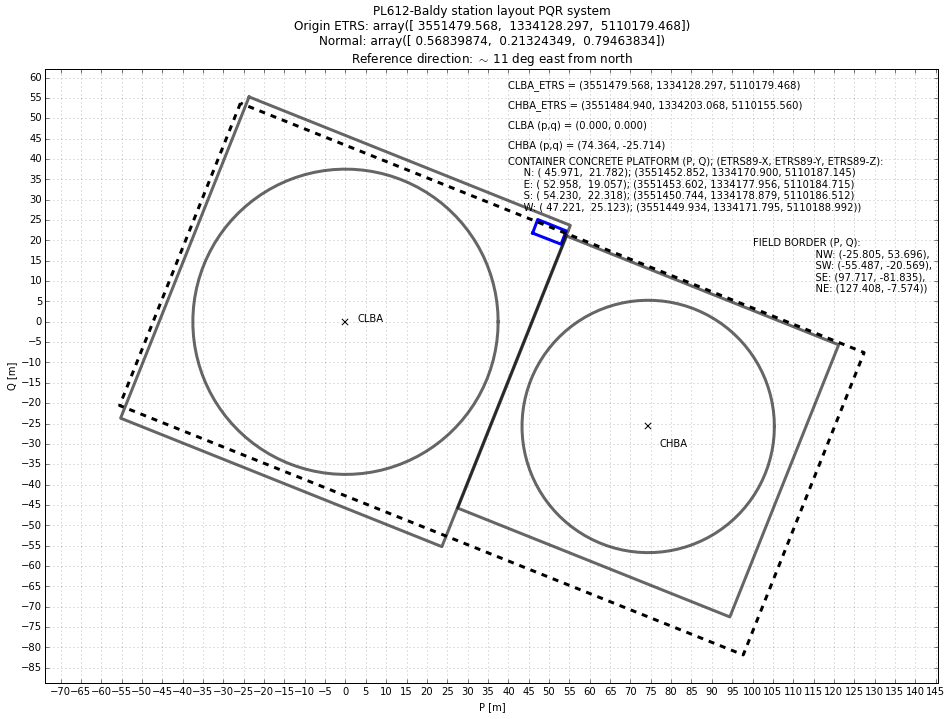

In [112]:
figure(figsize=(16, 11))
#imshow(r_m, origin='lower', extent=(-150.5, 100.5, -55.5, 100.5), vmin=-4, vmax=+4, alpha=0.3)
grid(alpha=0.5)
#cb = colorbar()
#cb.set_label('Height deviation [m]')
#cnt = contour(p_m, q_m, r_m, levels=arange(-10.0, +10.0, 0.5), colors='black', alpha=0.3)
#cnt.clabel(inline=True)
axis('equal')
title('''Deviations from best-fit plane
Origin ETRS: %r\nNormal: %r''' %
      (solution['mean'], solution['normal']))
xlabel('P [m]')
ylabel('Q [m]')
xticks(arange(-200, 200, 5))
yticks(arange(-200, 200, 5))

#scatter(station_pqr[:,0], station_pqr[:,1], alpha=0.5)
#scatter(selection_pqr[:,0], selection_pqr[:,1], color='red', alpha=0.3)

lba_box_width_m = 85.0
hba_box_width_m = 72



container_pqr = transform(container_pos_etrs, CLBA_ETRS, rotation_matrix.T)
container_pqr = concatenate([container_pqr, container_pqr[0,:].reshape((1,3))], axis=0)
border_pqr = transform(border_pos_etrs, CLBA_ETRS, rotation_matrix.T)
border_pqr =  concatenate([border_pqr, border_pqr[0,:].reshape((1,3))], axis=0)
print(border_pqr)
plot(container_pqr[:,0], container_pqr[:,1], linewidth=3)
plot(border_pqr[:,0], border_pqr[:,1], linewidth=3, color='black', linestyle='--')
rot_ccw_rad = arctan2((border_pqr[2]-border_pqr[1])[1], (border_pqr[2]-border_pqr[1])[0])
rot_ccw_deg = rot_ccw_rad*180/pi
print(rot_ccw_deg)
lba_square = square_corners(lba_box_width_m, angle_rad=rot_ccw_rad)
hba_square = square_corners(hba_box_width_m, angle_rad=rot_ccw_rad)

chba_pqr = transform([CHBA_ETRS], CLBA_ETRS, rotation_matrix.T)[0]
#scatter(new_chba_pqr[0], new_chba_pqr[1], color='black', s=40, marker='x')
#text(new_chba_pqr[0]+3, new_chba_pqr[1]-5, 'CHBA', color='black')
plot(hba_square[:,0]+chba_pqr[0], hba_square[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_pqr[0], hba_circle[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
clba_pqr = transform([CLBA_ETRS], CLBA_ETRS, rotation_matrix.T)[0]
#scatter(new_clba_pqr[0], new_clba_pqr[1], color='black', s=40, marker='x')
#text(new_clba_pqr[0]+3, new_clba_pqr[1], 'CLBA', color='black')
plot(lba_square[:,0]+clba_pqr[0], lba_square[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_pqr[0], lba_circle[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')

#CHBA_ETRS = solution['mean']+(transform([new_chba_pqr], zeros(3), rotation_matrix)[0,:])
#CLBA_ETRS = solution['mean']+(transform([new_clba_pqr], zeros(3), rotation_matrix)[0,:])

scatter(chba_pqr[0], chba_pqr[1], color='black', s=40, marker='x')
text(chba_pqr[0]+3, chba_pqr[1]-5, 'CHBA', color='black')
scatter(clba_pqr[0], clba_pqr[1], color='black', s=40, marker='x')
text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='black')


title(r'''PL612-Baldy station layout PQR system
Origin ETRS: %r
Normal: %r
Reference direction: $\sim$ 11 deg east from north''' %
      (CLBA_ETRS, solution['normal']))
print(clba_pqr)
print(chba_pqr)
print(chba_pqr - clba_pqr)
lh=5
line=0.5
text(40, 60-line*lh, 'CLBA_ETRS = (%.3f, %.3f, %.3f)' % (CLBA_ETRS[0], CLBA_ETRS[1], CLBA_ETRS[2]))
line+=1
text(40, 60-line*lh, 'CHBA_ETRS = (%.3f, %.3f, %.3f)' % (CHBA_ETRS[0], CHBA_ETRS[1], CHBA_ETRS[2]))
line+=1
text(40, 60-line*lh, 'CLBA (p,q) = (%.3f, %.3f)' % (clba_pqr[0], clba_pqr[1]))
line+=1
text(40, 60-line*lh, 'CHBA (p,q) = (%.3f, %.3f)' % (chba_pqr[0], chba_pqr[1]))

line+=3
text(40, 60-line*lh,
     '''CONTAINER CONCRETE PLATFORM (P, Q); (ETRS89-X, ETRS89-Y, ETRS89-Z):
     N: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     E: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     S: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     W: (%7.3f, %7.3f); (%.3f, %.3f, %.3f))''' %
    tuple(concatenate([container_pqr[0:4,0:2], container_pos_etrs[0:4,:]], axis=1).ravel()))
line+=4
text(100, 60-line*lh,
     '''FIELD BORDER (P, Q):
                    NW: (%.3f, %.3f),
                    SW: (%.3f, %.3f),
                    SE: (%.3f, %.3f),
                    NE: (%.3f, %.3f))''' %
    tuple(border_pqr[0:4,0:2].ravel()))

savefig('pl612-station-overview-pqr-20150326.pdf')

<pre>
Hoi Michiel,
 
Bij het bepalen van de HBA bekabeling behorende bij het Baldy station is het nu toch gebleken dat het HBA veld in P/Q richting enigszins moet worden verschoven/verplaatst.
 
Oude coordinaten waren: 74.364, -25.714 ( P,Q)  (=X,Y)
Oude coordinaten waren: 74.864, -22.714 ( P,Q)  (=X,Y)
 
Het veld is dus 0.5m naar rechts (P (X) richting en 3m naar boven (Q (Y) richting.
 
Graag op basis van deze gegevens een nieuwe kaart en ETRS coördinaten van het HBA veld genereren/creëren.
 
Eim 
</pre>

In [113]:
CLBA_ETRS = array([3551479.568, 1334128.297, 5110179.468])
CHBA_ETRS = transform([array([74.864, -22.714,0.0])], zeros(3), rotation_matrix)[0,:] + CLBA_ETRS

[[ -2.58053773e+01   5.36961244e+01  -2.03054117e+00]
 [ -5.54865297e+01  -2.05689108e+01  -2.95972972e-02]
 [  9.77166603e+01  -8.18354997e+01   8.47218308e-01]
 [  1.27408084e+02  -7.57435426e+00  -2.78480099e-01]
 [ -2.58053773e+01   5.36961244e+01  -2.03054117e+00]]
-21.7966741991
[ 0.  0.  0.]
[  7.48640000e+01  -2.27140000e+01   2.41932696e-10]
[  7.48640000e+01  -2.27140000e+01   2.41932696e-10]


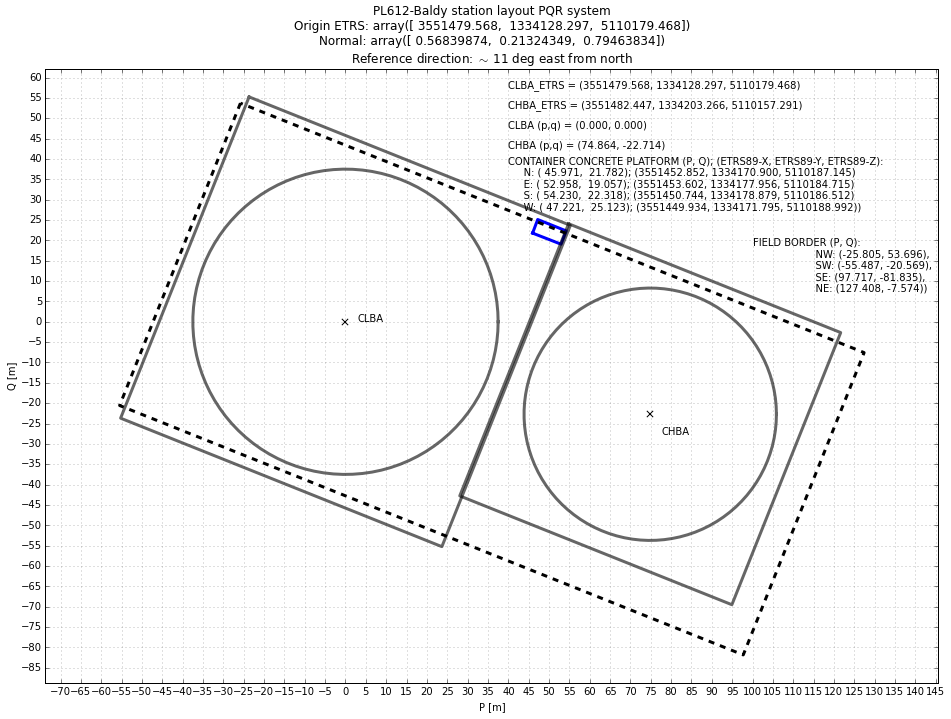

In [114]:
figure(figsize=(16, 11))
#imshow(r_m, origin='lower', extent=(-150.5, 100.5, -55.5, 100.5), vmin=-4, vmax=+4, alpha=0.3)
grid(alpha=0.5)
#cb = colorbar()
#cb.set_label('Height deviation [m]')
#cnt = contour(p_m, q_m, r_m, levels=arange(-10.0, +10.0, 0.5), colors='black', alpha=0.3)
#cnt.clabel(inline=True)
axis('equal')
title('''Deviations from best-fit plane
Origin ETRS: %r\nNormal: %r''' %
      (solution['mean'], solution['normal']))
xlabel('P [m]')
ylabel('Q [m]')
xticks(arange(-200, 200, 5))
yticks(arange(-200, 200, 5))

#scatter(station_pqr[:,0], station_pqr[:,1], alpha=0.5)
#scatter(selection_pqr[:,0], selection_pqr[:,1], color='red', alpha=0.3)

lba_box_width_m = 85.0
hba_box_width_m = 72



container_pqr = transform(container_pos_etrs, CLBA_ETRS, rotation_matrix.T)
container_pqr = concatenate([container_pqr, container_pqr[0,:].reshape((1,3))], axis=0)
border_pqr = transform(border_pos_etrs, CLBA_ETRS, rotation_matrix.T)
border_pqr =  concatenate([border_pqr, border_pqr[0,:].reshape((1,3))], axis=0)
print(border_pqr)
plot(container_pqr[:,0], container_pqr[:,1], linewidth=3)
plot(border_pqr[:,0], border_pqr[:,1], linewidth=3, color='black', linestyle='--')
rot_ccw_rad = arctan2((border_pqr[2]-border_pqr[1])[1], (border_pqr[2]-border_pqr[1])[0])
rot_ccw_deg = rot_ccw_rad*180/pi
print(rot_ccw_deg)
lba_square = square_corners(lba_box_width_m, angle_rad=rot_ccw_rad)
hba_square = square_corners(hba_box_width_m, angle_rad=rot_ccw_rad)

chba_pqr = transform([CHBA_ETRS], CLBA_ETRS, rotation_matrix.T)[0]
#scatter(new_chba_pqr[0], new_chba_pqr[1], color='black', s=40, marker='x')
#text(new_chba_pqr[0]+3, new_chba_pqr[1]-5, 'CHBA', color='black')
plot(hba_square[:,0]+chba_pqr[0], hba_square[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_pqr[0], hba_circle[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
clba_pqr = transform([CLBA_ETRS], CLBA_ETRS, rotation_matrix.T)[0]
#scatter(new_clba_pqr[0], new_clba_pqr[1], color='black', s=40, marker='x')
#text(new_clba_pqr[0]+3, new_clba_pqr[1], 'CLBA', color='black')
plot(lba_square[:,0]+clba_pqr[0], lba_square[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_pqr[0], lba_circle[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')

#CHBA_ETRS = solution['mean']+(transform([new_chba_pqr], zeros(3), rotation_matrix)[0,:])
#CLBA_ETRS = solution['mean']+(transform([new_clba_pqr], zeros(3), rotation_matrix)[0,:])

scatter(chba_pqr[0], chba_pqr[1], color='black', s=40, marker='x')
text(chba_pqr[0]+3, chba_pqr[1]-5, 'CHBA', color='black')
scatter(clba_pqr[0], clba_pqr[1], color='black', s=40, marker='x')
text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='black')


title(r'''PL612-Baldy station layout PQR system
Origin ETRS: %r
Normal: %r
Reference direction: $\sim$ 11 deg east from north''' %
      (CLBA_ETRS, solution['normal']))
print(clba_pqr)
print(chba_pqr)
print(chba_pqr - clba_pqr)
lh=5
line=0.5
text(40, 60-line*lh, 'CLBA_ETRS = (%.3f, %.3f, %.3f)' % (CLBA_ETRS[0], CLBA_ETRS[1], CLBA_ETRS[2]))
line+=1
text(40, 60-line*lh, 'CHBA_ETRS = (%.3f, %.3f, %.3f)' % (CHBA_ETRS[0], CHBA_ETRS[1], CHBA_ETRS[2]))
line+=1
text(40, 60-line*lh, 'CLBA (p,q) = (%.3f, %.3f)' % (clba_pqr[0], clba_pqr[1]))
line+=1
text(40, 60-line*lh, 'CHBA (p,q) = (%.3f, %.3f)' % (chba_pqr[0], chba_pqr[1]))

line+=3
text(40, 60-line*lh,
     '''CONTAINER CONCRETE PLATFORM (P, Q); (ETRS89-X, ETRS89-Y, ETRS89-Z):
     N: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     E: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     S: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     W: (%7.3f, %7.3f); (%.3f, %.3f, %.3f))''' %
    tuple(concatenate([container_pqr[0:4,0:2], container_pos_etrs[0:4,:]], axis=1).ravel()))
line+=4
text(100, 60-line*lh,
     '''FIELD BORDER (P, Q):
                    NW: (%.3f, %.3f),
                    SW: (%.3f, %.3f),
                    SE: (%.3f, %.3f),
                    NE: (%.3f, %.3f))''' %
    tuple(border_pqr[0:4,0:2].ravel()))

savefig('pl612-station-overview-pqr-20150429.pdf')

## Reference direction

The reference direction is the northern bisector of the X- and Y- dipoles. It is the second column of the rotation matrix. At LOFAR core station CS002 LBA, the reference direction coincides with true north, but elsewhere there is a slight deviation to ensure that all dipoles in LOFAR are oriented as similarly as possible. In this section, I determine the deviation between the reference direction (the "q" axis) and geographic north in the ETRS89 reference system.

In [115]:
ref_dir = rotation_matrix[:,1] 
print('Reference direction (q direction in ETRS89): ', ref_dir)

Reference direction (q direction in ETRS89):  [-0.79720901 -0.09605178  0.59601329]


To determine the angle between the reference direction of the station and ETRS89 north, we need to project the reference direction onto the tangent plane to the ellipsoid at the mean position of the field, and compute the normalized inner product between the "reference direction" of the local north frame and the projected reference direction.

In [116]:
tip_refdir = solution['mean']+ref_dir
projected_tip_ref_dir = transform(array([tip_refdir]), solution['mean'],
                                  local_north_projection.T)[0]
projected_tip_ref_dir[2] = 0.0
projected_tip_ref_dir = dot(local_north_projection, projected_tip_ref_dir)
projected_tip_ref_dir /= norm(projected_tip_ref_dir)

etrs_north = local_north_projection[:,1]
deviation = arccos(inner(etrs_north, projected_tip_ref_dir))

In [117]:
print ('First estimate of reference direction for PL612 Baldy is\
 %.4f degrees east from north.' %
       (deviation*180/pi,))

First estimate of reference direction for PL612 Baldy is 10.9795 degrees east from north.


## Preliminary antenna stake position map

In [118]:
lba_stakes_pqr_rows = [(row[0], array([float(x) for x in row[1:]]))
                       for row in csv.reader(open('pl612-lba-stakes-pqr.csv', 'r'))
                       if 'STATION-P' not in row]
hba_stakes_pqr_rows = [(row[0], array([float(x) for x in row[1:]]))
                       for row in csv.reader(open('pl612-hba-stakes-pqr.csv', 'r'))
                       if 'STATION-P' not in row]
lba_stakes_etrs = [(name, CLBA_ETRS + transform([pqr], zeros(3), rotation_matrix)[0,:])
                   for name, pqr in lba_stakes_pqr_rows]
hba_stakes_etrs = [(name, CHBA_ETRS + transform([pqr], zeros(3), rotation_matrix)[0,:])
                   for name, pqr in hba_stakes_pqr_rows]
lba_stakes_local = [(name, transform([pqr], CLBA_ETRS , local_north_projection.T)[0,:])
                   for name, pqr in lba_stakes_etrs]
hba_stakes_local = [(name, transform([pqr], CLBA_ETRS , local_north_projection.T)[0,:])
                   for name, pqr in hba_stakes_etrs]

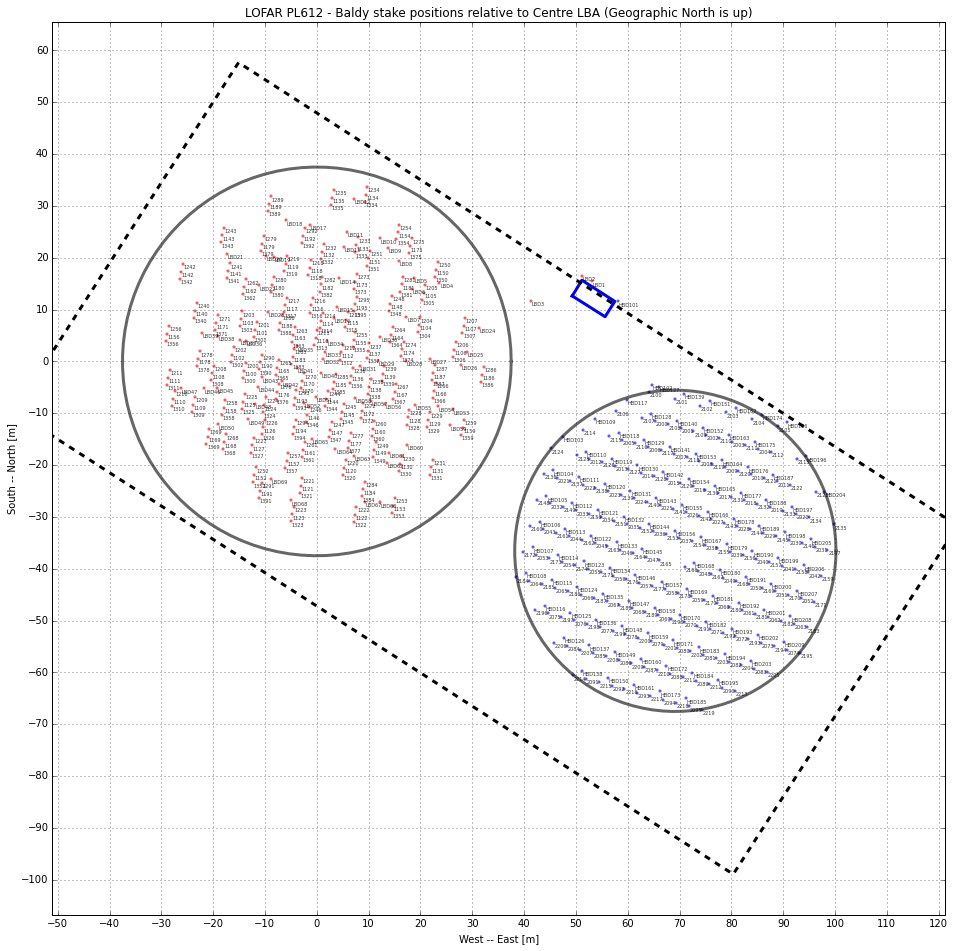

In [119]:
figure(figsize=(16,16))

for name, pqr in lba_stakes_local:
    scatter(pqr[0], pqr[1], alpha=0.5, s=5, color='red')
    text(pqr[0]+.2, pqr[1]-.2, name, fontsize=5, alpha=0.8,
         verticalalignment='top')
for name, pqr in hba_stakes_local:
    scatter(pqr[0], pqr[1], alpha=0.5, s=5, color='blue')
    text(pqr[0]+.2, pqr[1]-.2, name, fontsize=5, alpha=0.8,
         verticalalignment='top')
border_local = transform(border_pos_etrs, CLBA_ETRS, local_north_projection.T)
border_local =  concatenate([border_local, border_local[0,:].reshape((1,3))], axis=0)
container_local = transform(container_pos_etrs, CLBA_ETRS, local_north_projection.T)
container_local = concatenate([container_local, container_local[0,:].reshape((1,3))], axis=0)

plot(container_local[:,0], container_local[:,1], linewidth=3)
plot(border_local[:,0], border_local[:,1], linewidth=3, color='black', linestyle='--')

chba_local = transform([CHBA_ETRS], CLBA_ETRS, local_north_projection.T)[0]
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_local[0], hba_circle[:,1]+chba_local[1], linewidth=3, alpha=0.6, color='black')
clba_local = transform([CLBA_ETRS], CLBA_ETRS, local_north_projection.T)[0]
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_local[0], lba_circle[:,1]+clba_local[1], linewidth=3, alpha=0.6, color='black')


xticks(arange(-150,170,10))
yticks(arange(-150, 80,10))
axis('equal')
grid()
xlim(-50,120)
xlabel('West -- East [m]')
ylabel('South -- North [m]')
title('LOFAR PL612 - Baldy stake positions relative to Centre LBA (Geographic North is up)')
savefig('pl612-stake-positions.pdf')

In [120]:
def write_etrs_stakes_file(file_name, stakes_etrs, centre_etrs, matrix_pqr_to_etrs):
    with open(file_name, 'w') as out:
        writer = csv.writer(out)
        writer.writerow(['NAME', 'ETRS-X', 'ETRS-Y', 'ETRS-Z', 'STATION_P', 'STATION_Q', 'STATION_R'])
        for name, etrs in stakes_etrs:
            pqr = transform([etrs], centre_etrs, matrix_pqr_to_etrs.T)[0,:]
            row = [name,
                   '%.3f' % etrs[0],
                   '%.3f' % etrs[1],
                   '%.3f' % etrs[2],
                   '%.3f' % pqr[0],
                   '%.3f' % pqr[1],
                   '%.3f' % pqr[2]]
            writer.writerow(row)
    pass
    

In [121]:
#write_etrs_stakes_file('pl612-lba-stakes-etrs.csv', lba_stakes_etrs, CLBA_ETRS, rotation_matrix)
#write_etrs_stakes_file('pl612-hba-stakes-etrs.csv', hba_stakes_etrs, CHBA_ETRS, rotation_matrix)

## Final flattening analysis

In [122]:
file_name = 'pl612-final-survey-2015-05-18/XYZ_GRS3-grid'
final_survey_etrs = array([[float(number) for number in line.split()[1:4]] for line in open(file_name).readlines() if line.strip() != ''])

0.063490806414645898

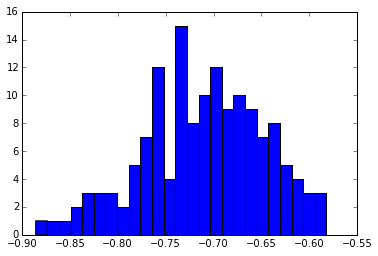

In [123]:
final_survey_pqr_lba = array([pqr for pqr in transform(final_survey_etrs, CLBA_ETRS, local_north_projection.T)
                            if norm(pqr[0:2]) < (LBA_CIRCLE_DIAMETER/2.0)])

pqr_lba_interpol_fn = interpolation_function(final_survey_pqr_lba)
lba_p_m, lba_q_m = meshgrid(arange(-50, 50), arange(-50, 50))
lba_r_m = pqr_lba_interpol_fn(lba_p_m, lba_q_m)
hist(final_survey_pqr_lba[:,2], bins=25)
final_survey_pqr_lba[:,2].std()

0.038977035144938076

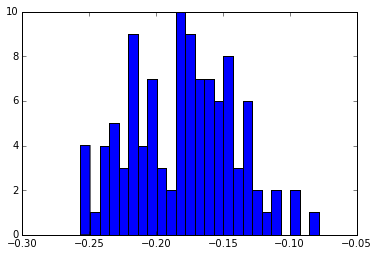

In [124]:
final_survey_pqr_hba = array([pqr for pqr in transform(final_survey_etrs, CHBA_ETRS, local_north_projection.T)
                            if norm(pqr[0:2]) < (HBA_CIRCLE_DIAMETER/2.0)])

pqr_hba_interpol_fn = interpolation_function(final_survey_pqr_hba)
hba_p_m, hba_q_m = meshgrid(arange(-50, 50), arange(-50, 50))
hba_r_m = pqr_hba_interpol_fn(hba_p_m, hba_q_m)
hist(final_survey_pqr_hba[:,2], bins=25)
final_survey_pqr_hba[:,2].std()

(array([ 2.04776788,  3.18703684, -0.71086156]),
 array([ 1.39874256,  2.03075708, -0.18010579]))

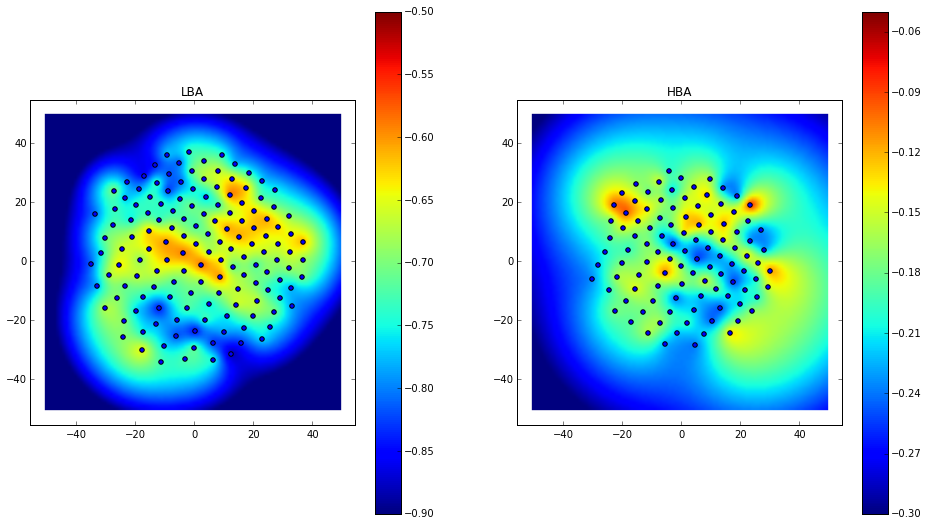

In [125]:
figure(figsize=(16, 9))

subplot(121)
title('LBA')
imshow(lba_r_m, origin='lower', extent=(lba_p_m.min()-0.5, lba_p_m.max()+0.5, lba_q_m.min()-0.5, lba_q_m.max()+0.5),
      vmin=-.9, vmax=-.5)
colorbar()
scatter(final_survey_pqr_lba[:,0],final_survey_pqr_lba[:,1])

subplot(122)
title('HBA')
imshow(hba_r_m, origin='lower', extent=(hba_p_m.min()-0.5, hba_p_m.max()+0.5, hba_q_m.min()-0.5, hba_q_m.max()+0.5),
      vmin=-.30, vmax=-0.05)
colorbar()
scatter(final_survey_pqr_hba[:,0],final_survey_pqr_hba[:,1])

final_survey_pqr_lba.mean(axis=0), final_survey_pqr_hba.mean(axis=0)

In [141]:
CLBA_FINAL_ETRS = (transform([[0,0,-0.71086]], zeros(3), local_north_projection))[0,:] + CLBA_ETRS
CHBA_FINAL_ETRS = (transform([[0,0,-0.180106]], zeros(3), local_north_projection))[0,:] + CHBA_ETRS
print('CLBA_FINAL_ETRS: ', CLBA_FINAL_ETRS)
print('CHBA_FINAL_ETRS: ', CHBA_FINAL_ETRS)

CLBA_FINAL_ETRS:  [ 3551479.17304474  1334128.14863322  5110178.89588149]
CHBA_FINAL_ETRS:  [ 3551482.34672509  1334203.22885474  5110157.14560046]


In [127]:
final_rotation_matrix = projection_matrix(LOFAR_XYZ0_m, local_north_projection[:,2])
print('Normal vector: ', repr(local_north_projection[:,2]))
print('Rotation matrix:\n', repr(final_rotation_matrix))
final_ref_dir = final_rotation_matrix[:,1] 
print('Reference direction (q direction in ETRS89): ', final_ref_dir)

final_tip_refdir = CLBA_FINAL_ETRS+final_ref_dir
projected_tip_ref_dir = transform(array([final_tip_refdir]), CLBA_FINAL_ETRS,
                                  local_north_projection.T)[0]
projected_tip_ref_dir[2] = 0.0
projected_tip_ref_dir = dot(local_north_projection, projected_tip_ref_dir)
projected_tip_ref_dir /= norm(projected_tip_ref_dir)

etrs_north = local_north_projection[:,1]
deviation = arccos(inner(etrs_north, projected_tip_ref_dir))
print('Reference direction: %.3f deg East of North' % (deviation*180/pi,))

Normal vector:  array([ 0.55560203,  0.20871448,  0.80482585])
Rotation matrix:
 array([[-0.19981282, -0.80708192,  0.55560203],
       [ 0.9731302 , -0.09724131,  0.20871448],
       [-0.11442221,  0.58237694,  0.80482585]])
Reference direction (q direction in ETRS89):  [-0.80708192 -0.09724131  0.58237694]
Reference direction: 11.116 deg East of North


(0.063490806414645939, -1.5559915590986461e-06)

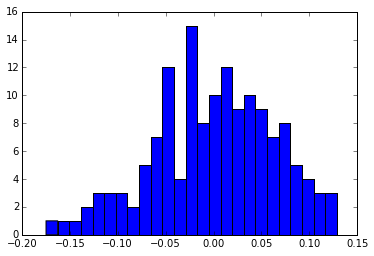

In [128]:
final_survey_pqr_lba = array([pqr for pqr in transform(final_survey_etrs, CLBA_FINAL_ETRS, final_rotation_matrix.T)
                            if norm(pqr[0:2]) < (LBA_CIRCLE_DIAMETER/2.0)])

pqr_lba_interpol_fn = interpolation_function(final_survey_pqr_lba)
lba_p_m, lba_q_m = meshgrid(arange(-50, 50), arange(-50, 50))
lba_r_m = pqr_lba_interpol_fn(lba_p_m, lba_q_m)
hist(final_survey_pqr_lba[:,2], bins=25)
final_survey_pqr_lba[:,2].std(),final_survey_pqr_lba[:,2].mean(),

(0.038977035144938117, 2.060331965521379e-07)

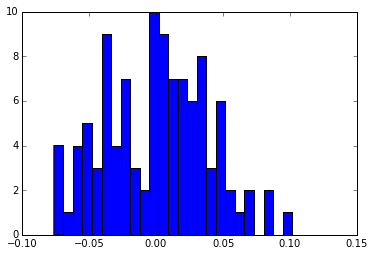

In [129]:
final_survey_pqr_hba = array([pqr for pqr in transform(final_survey_etrs, CHBA_FINAL_ETRS, final_rotation_matrix.T)
                            if norm(pqr[0:2]) < (HBA_CIRCLE_DIAMETER/2.0)])

pqr_hba_interpol_fn = interpolation_function(final_survey_pqr_hba)
hba_p_m, hba_q_m = meshgrid(arange(-50, 50), arange(-50, 50))
hba_r_m = pqr_hba_interpol_fn(hba_p_m, hba_q_m)
hist(final_survey_pqr_hba[:,2], bins=25)
final_survey_pqr_hba[:,2].std(),final_survey_pqr_hba[:,2].mean()

## Final stake positions

In [130]:
final_lba_stakes_pqr_rows = [(row[0], array([float(x) for x in row[1:]]))
                       for row in csv.reader(open('pl612-lba-stakes-pqr.csv', 'r'))
                       if 'STATION-P' not in row]
final_hba_stakes_pqr_rows = [(row[0], array([float(x) for x in row[1:]]))
                       for row in csv.reader(open('pl612-hba-stakes-pqr.csv', 'r'))
                       if 'STATION-P' not in row]
final_lba_stakes_etrs = [(name, CLBA_FINAL_ETRS + transform([pqr], zeros(3), final_rotation_matrix)[0,:])
                   for name, pqr in final_lba_stakes_pqr_rows]
final_hba_stakes_etrs = [(name, CHBA_FINAL_ETRS + transform([pqr], zeros(3), final_rotation_matrix)[0,:])
                   for name, pqr in final_hba_stakes_pqr_rows]

final_lba_stakes_local = [(name, transform([pqr], CLBA_FINAL_ETRS , local_north_projection.T)[0,:])
                   for name, pqr in final_lba_stakes_etrs]
final_hba_stakes_local = [(name, transform([pqr], CLBA_FINAL_ETRS , local_north_projection.T)[0,:])
                   for name, pqr in final_hba_stakes_etrs]

final_lba_stakes_pqr = [(name, transform([pqr], CLBA_FINAL_ETRS , final_rotation_matrix.T)[0,:])
                   for name, pqr in final_lba_stakes_etrs]
final_hba_stakes_pqr = [(name, transform([pqr], CLBA_FINAL_ETRS , final_rotation_matrix.T)[0,:])
                   for name, pqr in final_hba_stakes_etrs]


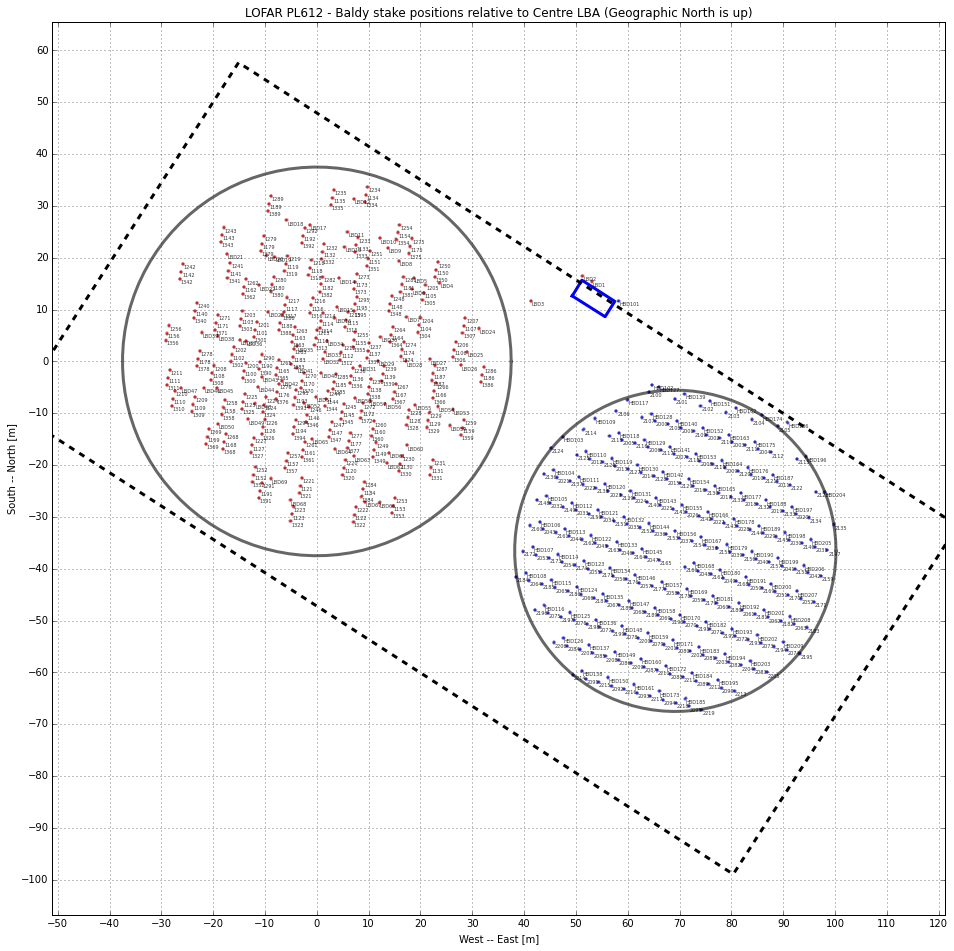

In [131]:
figure(figsize=(16,16))

for name, pqr in lba_stakes_local:
    scatter(pqr[0], pqr[1], alpha=0.4, s=5, color='black')
for name, pqr in hba_stakes_local:
    scatter(pqr[0], pqr[1], alpha=0.4, s=5, color='black')


for name, pqr in final_lba_stakes_local:
    scatter(pqr[0], pqr[1], alpha=0.5, s=5, color='red')
    text(pqr[0]+.2, pqr[1]-.2, name, fontsize=5, alpha=0.8,
         verticalalignment='top')
for name, pqr in final_hba_stakes_local:
    scatter(pqr[0], pqr[1], alpha=0.5, s=5, color='blue')
    text(pqr[0]+.2, pqr[1]-.2, name, fontsize=5, alpha=0.8,
         verticalalignment='top')
border_local = transform(border_pos_etrs, CLBA_FINAL_ETRS, local_north_projection.T)
border_local =  concatenate([border_local, border_local[0,:].reshape((1,3))], axis=0)
container_local = transform(container_pos_etrs, CLBA_FINAL_ETRS, local_north_projection.T)
container_local = concatenate([container_local, container_local[0,:].reshape((1,3))], axis=0)

plot(container_local[:,0], container_local[:,1], linewidth=3)
plot(border_local[:,0], border_local[:,1], linewidth=3, color='black', linestyle='--')

chba_local = transform([CHBA_FINAL_ETRS], CLBA_FINAL_ETRS, local_north_projection.T)[0]
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_local[0], hba_circle[:,1]+chba_local[1], linewidth=3, alpha=0.6, color='black')
clba_local = transform([CLBA_FINAL_ETRS], CLBA_FINAL_ETRS, local_north_projection.T)[0]
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_local[0], lba_circle[:,1]+clba_local[1], linewidth=3, alpha=0.6, color='black')


xticks(arange(-150,170,10))
yticks(arange(-150, 80,10))
axis('equal')
grid()
xlim(-50,120)
xlabel('West -- East [m]')
ylabel('South -- North [m]')
title('LOFAR PL612 - Baldy stake positions relative to Centre LBA (Geographic North is up)')
savefig('pl612-stake-positions-20150610.pdf')

[[ -2.59388643e+01   5.36597986e+01  -3.45407857e-01]
 [ -5.54373495e+01  -2.07000703e+01   5.02714956e-01]
 [  9.79128923e+01  -8.16009816e+01  -1.00197540e-01]
 [  1.27424297e+02  -7.25959475e+00  -7.32965004e-02]
 [ -2.59388643e+01   5.36597986e+01  -3.45407857e-01]]
-21.659811749
[ 0.  0.  0.]
[  7.49174045e+01  -2.25291816e+01  -7.15558387e-02]
[  7.49174045e+01  -2.25291816e+01  -7.15558387e-02]


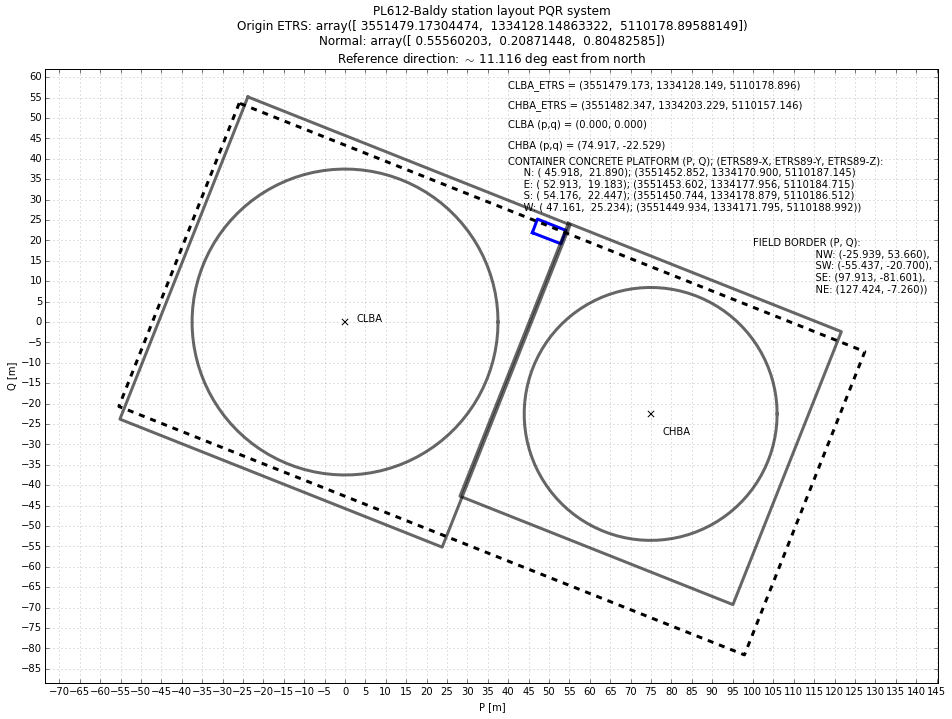

In [132]:
figure(figsize=(16, 11))
#imshow(r_m, origin='lower', extent=(-150.5, 100.5, -55.5, 100.5), vmin=-4, vmax=+4, alpha=0.3)
grid(alpha=0.5)
#cb = colorbar()
#cb.set_label('Height deviation [m]')
#cnt = contour(p_m, q_m, r_m, levels=arange(-10.0, +10.0, 0.5), colors='black', alpha=0.3)
#cnt.clabel(inline=True)
axis('equal')
title('''Deviations from best-fit plane
Origin ETRS: %r\nNormal: %r''' %
      (solution['mean'], solution['normal']))
xlabel('P [m]')
ylabel('Q [m]')
xticks(arange(-200, 200, 5))
yticks(arange(-200, 200, 5))

#scatter(station_pqr[:,0], station_pqr[:,1], alpha=0.5)
#scatter(selection_pqr[:,0], selection_pqr[:,1], color='red', alpha=0.3)

lba_box_width_m = 85.0
hba_box_width_m = 72



container_pqr = transform(container_pos_etrs, CLBA_FINAL_ETRS, final_rotation_matrix.T)
container_pqr = concatenate([container_pqr, container_pqr[0,:].reshape((1,3))], axis=0)
border_pqr = transform(border_pos_etrs, CLBA_FINAL_ETRS, final_rotation_matrix.T)
border_pqr =  concatenate([border_pqr, border_pqr[0,:].reshape((1,3))], axis=0)
print(border_pqr)
plot(container_pqr[:,0], container_pqr[:,1], linewidth=3)
plot(border_pqr[:,0], border_pqr[:,1], linewidth=3, color='black', linestyle='--')
rot_ccw_rad = arctan2((border_pqr[2]-border_pqr[1])[1], (border_pqr[2]-border_pqr[1])[0])
rot_ccw_deg = rot_ccw_rad*180/pi
print (rot_ccw_deg)
lba_square = square_corners(lba_box_width_m, angle_rad=rot_ccw_rad)
hba_square = square_corners(hba_box_width_m, angle_rad=rot_ccw_rad)

chba_pqr = transform([CHBA_FINAL_ETRS], CLBA_FINAL_ETRS, final_rotation_matrix.T)[0]
#scatter(new_chba_pqr[0], new_chba_pqr[1], color='black', s=40, marker='x')
#text(new_chba_pqr[0]+3, new_chba_pqr[1]-5, 'CHBA', color='black')
plot(hba_square[:,0]+chba_pqr[0], hba_square[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_pqr[0], hba_circle[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
clba_pqr = transform([CLBA_FINAL_ETRS], CLBA_FINAL_ETRS, rotation_matrix.T)[0]
#scatter(new_clba_pqr[0], new_clba_pqr[1], color='black', s=40, marker='x')
#text(new_clba_pqr[0]+3, new_clba_pqr[1], 'CLBA', color='black')
plot(lba_square[:,0]+clba_pqr[0], lba_square[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_pqr[0], lba_circle[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')

#CHBA_ETRS = solution['mean']+(transform([new_chba_pqr], zeros(3), rotation_matrix)[0,:])
#CLBA_ETRS = solution['mean']+(transform([new_clba_pqr], zeros(3), rotation_matrix)[0,:])

scatter(chba_pqr[0], chba_pqr[1], color='black', s=40, marker='x')
text(chba_pqr[0]+3, chba_pqr[1]-5, 'CHBA', color='black')
scatter(clba_pqr[0], clba_pqr[1], color='black', s=40, marker='x')
text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='black')


title(r'''PL612-Baldy station layout PQR system
Origin ETRS: %r
Normal: %r
Reference direction: $\sim$ 11.116 deg east from north''' %
      (CLBA_FINAL_ETRS, final_rotation_matrix[:,2]))
print(clba_pqr)
print(chba_pqr)
print(chba_pqr - clba_pqr)
lh=5
line=0.5
text(40, 60-line*lh, 'CLBA_ETRS = (%.3f, %.3f, %.3f)' % (CLBA_FINAL_ETRS[0], CLBA_FINAL_ETRS[1], CLBA_FINAL_ETRS[2]))
line+=1
text(40, 60-line*lh, 'CHBA_ETRS = (%.3f, %.3f, %.3f)' % (CHBA_FINAL_ETRS[0], CHBA_FINAL_ETRS[1], CHBA_FINAL_ETRS[2]))
line+=1
text(40, 60-line*lh, 'CLBA (p,q) = (%.3f, %.3f)' % (clba_pqr[0], clba_pqr[1]))
line+=1
text(40, 60-line*lh, 'CHBA (p,q) = (%.3f, %.3f)' % (chba_pqr[0], chba_pqr[1]))

line+=3
text(40, 60-line*lh,
     '''CONTAINER CONCRETE PLATFORM (P, Q); (ETRS89-X, ETRS89-Y, ETRS89-Z):
     N: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     E: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     S: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     W: (%7.3f, %7.3f); (%.3f, %.3f, %.3f))''' %
    tuple(concatenate([container_pqr[0:4,0:2], container_pos_etrs[0:4,:]], axis=1).ravel()))
line+=4
text(100, 60-line*lh,
     '''FIELD BORDER (P, Q):
                    NW: (%.3f, %.3f),
                    SW: (%.3f, %.3f),
                    SE: (%.3f, %.3f),
                    NE: (%.3f, %.3f))''' %
    tuple(border_pqr[0:4,0:2].ravel()))

savefig('pl612-station-overview-pqr-20150601.pdf')

In [133]:
write_etrs_stakes_file('pl612-lba-stakes-etrs-20150602.csv', final_lba_stakes_etrs, CLBA_FINAL_ETRS, final_rotation_matrix)
write_etrs_stakes_file('pl612-hba-stakes-etrs-20150602.csv', final_hba_stakes_etrs, CHBA_FINAL_ETRS, final_rotation_matrix)

In [134]:
diffs_lba = array([norm(new[0:2]-old[0:2]) for (newname, new), (olname, old) in zip(lba_stakes_local, final_lba_stakes_local)])
diffs_hba = array([norm(new[0:2]-old[0:2]) for (newname, new), (olname, old) in zip(hba_stakes_local, final_hba_stakes_local)])

(array([ 25.,  54.,  70.,  66.,  78.,  58.,   3.,   1.,   0.,   2.]),
 array([ 0.00316969,  0.01589196,  0.02861423,  0.0413365 ,  0.05405877,
         0.06678104,  0.07950331,  0.09222559,  0.10494786,  0.11767013,
         0.1303924 ]),
 <a list of 10 Patch objects>)

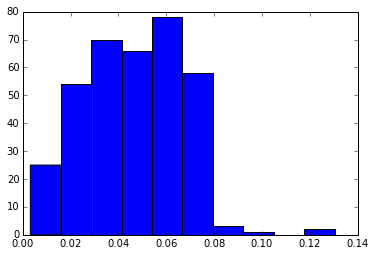

In [135]:
hist(diffs_lba)

(array([ 14.,  33.,  50.,  66.,  79.,  73.,   9.,   0.,   0.,   1.]),
 array([ 0.00610429,  0.01753222,  0.02896015,  0.04038808,  0.05181601,
         0.06324394,  0.07467187,  0.08609979,  0.09752772,  0.10895565,
         0.12038358]),
 <a list of 10 Patch objects>)

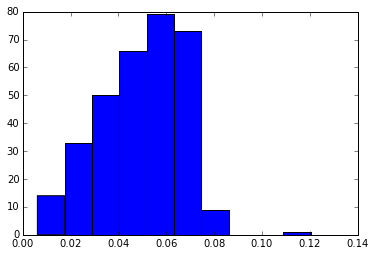

In [136]:
hist(diffs_hba)

In [137]:
dot(ref_dir, final_ref_dir)

0.99985758031727279

In [138]:
cos(pi/180.0)

0.99984769515639127

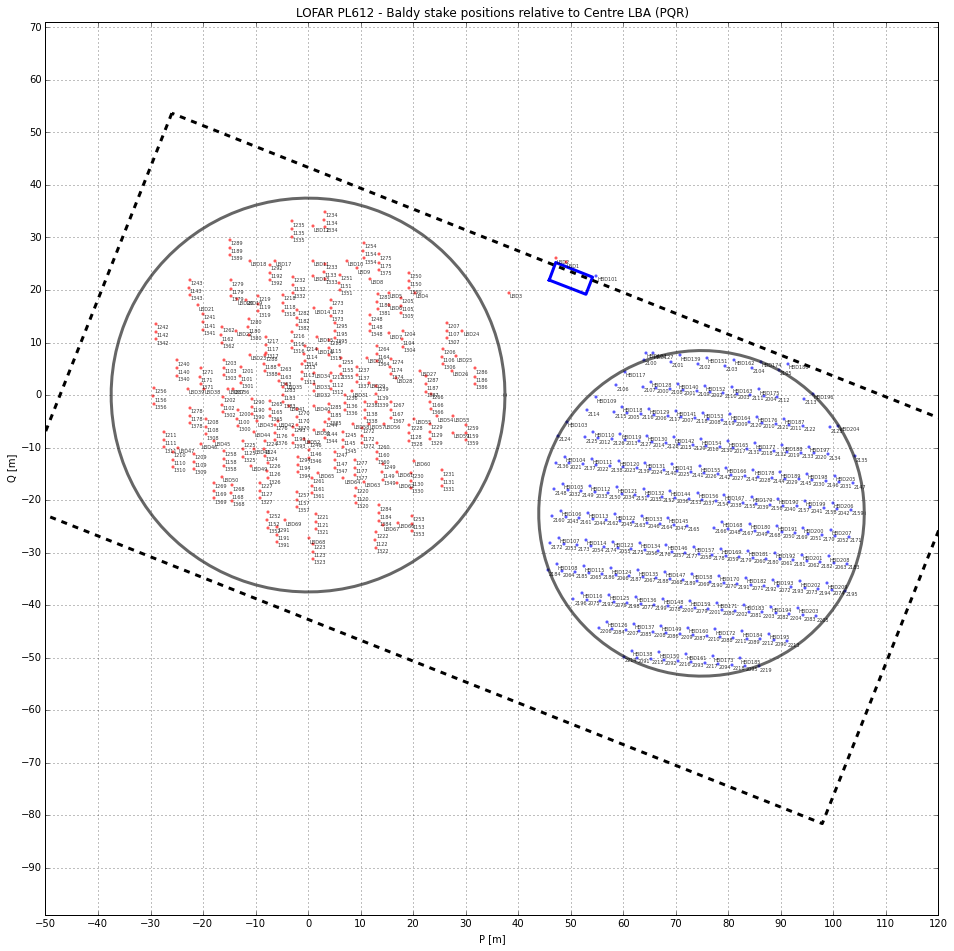

In [139]:
figure(figsize=(16,16))

for name, pqr in final_lba_stakes_pqr:
    scatter(pqr[0], pqr[1], alpha=0.5, s=5, color='red')
    text(pqr[0]+.2, pqr[1]-.2, name, fontsize=5, alpha=0.8,
         verticalalignment='top')
for name, pqr in final_hba_stakes_pqr:
    scatter(pqr[0], pqr[1], alpha=0.5, s=5, color='blue')
    text(pqr[0]+.2, pqr[1]-.2, name, fontsize=5, alpha=0.8,
         verticalalignment='top')
border_local = transform(border_pos_etrs, CLBA_FINAL_ETRS, final_rotation_matrix.T)
border_local =  concatenate([border_local, border_local[0,:].reshape((1,3))], axis=0)
container_local = transform(container_pos_etrs, CLBA_FINAL_ETRS, final_rotation_matrix.T)
container_local = concatenate([container_local, container_local[0,:].reshape((1,3))], axis=0)

plot(container_local[:,0], container_local[:,1], linewidth=3)
plot(border_local[:,0], border_local[:,1], linewidth=3, color='black', linestyle='--')

chba_local = transform([CHBA_FINAL_ETRS], CLBA_FINAL_ETRS, final_rotation_matrix.T)[0]
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_local[0], hba_circle[:,1]+chba_local[1], linewidth=3, alpha=0.6, color='black')
clba_local = transform([CLBA_FINAL_ETRS], CLBA_FINAL_ETRS, final_rotation_matrix.T)[0]
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_local[0], lba_circle[:,1]+clba_local[1], linewidth=3, alpha=0.6, color='black')


xticks(arange(-150,170,10))
yticks(arange(-150, 80,10))
axis('equal')
grid()
xlim(-50,120)
xlabel('P [m]')
ylabel('Q [m]')
title('LOFAR PL612 - Baldy stake positions relative to Centre LBA (PQR)')
savefig('pl612-stake-positions-20150610-pqr.pdf')